In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import glob
import pickle
import time

# Generative Adversarial Networks (GANs)

Highlighted by Yann Le Cun as one of *the* big developments in deep learning in the past couple of years, GANs have taken off big.

They were developed by Ian Goodfellow (a lead author on the new Deep Learning book http://www.deeplearningbook.org/) and have since then been extended in several applications.

Here is the classic publication from 2014:

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2014. Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).

In order to solve a certain task, a learning algorithms needs to be able to capture the relevant distributions of the data. In general, we have two approaches:

* discriminative approach: here we try to train a network that maps the input data $x$ to some desired output class label $y$. In probabilistic terms, this directly learns the conditional distribution $P(y|x)$.

* generative approach: we learn the joint probability distribution of the input data and labels simultaneously, i.e. $P(x,y)$. This can be converted to $P(y|x)$ for classification via Bayes' rule, of course. Importantly, however, we can use $P(x,y)$ to create new samples $(x,y)$ that have highlikelihood.

So far, we have used discriminative approaches in our DNNs.

What about combining the two approaches?

The basic idea of GANs is to let the two fight against each other. You have one generator that takes noise samples and tries to turn them into something that can fool a discriminator into thinking it belongs to one of the actual training samples. Both networks are trained together - in competition - and you use gradient updates from the discriminator to update the generator!

The following code heavily borrows from the nice introduction available at: https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

## Face dataset as class
Let's first define a class for the faces that we would like to learn from. We will derive this class from the PyTorch class `Dataset`, and will need to overload the constructor `__init__` and the indexing operator `__getitem__`. For convenience, we also define the length of the dataset and a function that shows a picture of the loaded data.

The dataset is already pickled and consists of >13000 cropped faces from the Labelled-Faces-In-The-Wild (LFW) dataset. 

In [2]:
class faceDataset(Dataset):
    """Face dataset."""
    def __init__(self, pickle_file, normalize=0):
        """
        Args:
            pickle_file (string): full path to pickled face data from LFW.
            normalize (callable, optional): Optional normalization of images
        """
        self.pickle_file = pickle_file
        self.normalize = normalize
        with open(self.pickle_file, 'rb') as fo:
            tmp = pickle.load(fo,encoding='bytes')
            if self.normalize==1:
                tmp = (tmp-tmp.mean(0))/tmp.std(0)
            if torch.torch.cuda.is_available():
                self.images = torch.from_numpy(tmp).cuda()
            else:
                self.images = torch.from_numpy(tmp)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample=self.images[idx,:]

        if self.normalize==2:
            sample = (sample-sample.mean())/sample.std()
        return sample
    def show(self,idx):
        plt.figure()
        plt.imshow(self.images[idx,:].cpu().numpy().reshape((32,32)),cmap='gray')

In [5]:
face_dataset = faceDataset(pickle_file='faces_python.pkl')

In order to make training more comfortable, we can use PyTorch's own `DataLoader` class, which takes a dataset and returns batches from it in an iterator. 

In [6]:
dataloader = DataLoader(face_dataset, batch_size=100,
                        shuffle=True, num_workers=0)
num_batches = len(dataloader)
print('face dataset has',len(face_dataset),'faces and',num_batches,'batches')

face dataset has 13233 faces and 133 batches


(-0.5, 341.5, 341.5, -0.5)

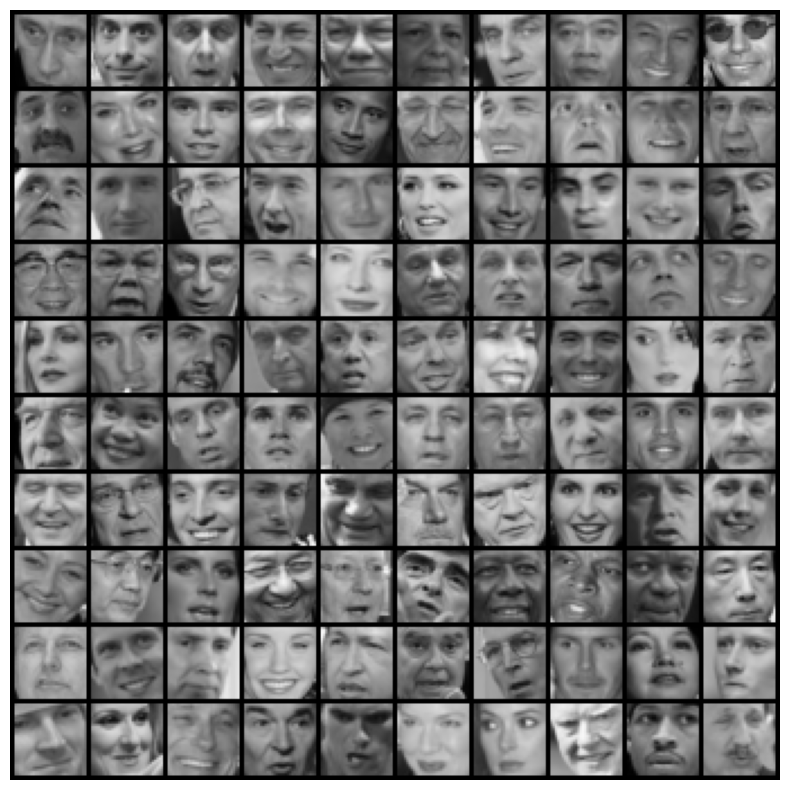

In [7]:
# sampling from dataloader and converting it to NCHW format
face_sample = next(iter(dataloader)).reshape(100,1,32,32)
face_grid = utils.make_grid(face_sample, nrow=10).cpu().numpy()

# Converting torch CHW format to matplotlib HWC format
face_grid = np.moveaxis(face_grid, 0, -1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(face_grid, cmap='gray')
ax.axis('off')

## Discriminator

We first define the discriminator, which is supposed to detect whether an image is fake or not.

It is derived from PyTorch's `nn.Module` and needs to provide the constructor `__init__` in which we set up the network layers and the `forward` function, which defines how to pass information from one layer to the next.

Here, we choose a very simple, fully-connected, three-layer network. The activation function is set to a leaky ReLU, which improves stability a bit, and the layers also implement dropout, which ignores a certain proportion of the weight updates.

The leaky ReLU function is defined as:

$\text{LeakyReLU}(\alpha,x) = \max(0, x) + \alpha * \min(0, x)$, or equivalently,
$
        \text{LeakyReLU}(\alpha,x) =
        \begin{cases}
        x, & \text{ if } x \geq 0 \\
        \alpha  x, & \text{ otherwise }
        \end{cases}
        $

In [8]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        # call the standard constructor from superclass
        super().__init__()
        # we need to classify an image
        n_features = 32*32
        # into whether it's fake or not
        n_out = 1
        # first layer
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # second layer
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # third layer
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # final decision
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            # it is important to have a sigmoid here - see below!
            torch.nn.Sigmoid()
        )
    # information just flows through
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.reset_parameters()

We next define two helper functions that convert images into vectors and vice versa, which will be helpful for visualization later on.

In [9]:
def images_to_vectors(images):
    return images.view(images.size(0), 32*32)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 32, 32)

def numpy_to_plotly(arr):
    tmp = (arr-arr.min())/(arr.max()-arr.min())*255
    return np.dstack((tmp,tmp,tmp))

## Generator

This class defines the generator, which takes noise as input and then generates a 32x32 pixel image from this.

In [10]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        # call the standard constructor from superclass
        super().__init__()
        # number of features we want to reconstruct from
        n_features = 100
        # and output image size
        n_out = 32*32
        
        # this architecture is simply the inverted discriminator
        # except without dropout
        
        # first layer
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        # second layer
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        # third layer
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        # create image
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    # pass through
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.reset_parameters()

In order to create the noise distribution from which the generator is supposed to work, we create a helper function:

In [11]:
# Noise
def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

## Training the GAN

First we instantiate the two networks, and push them to CUDA, if possible.

In [13]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
    
from modelsummary import summary
summary(discriminator, torch.zeros((1, 32*32)), show_input=True)
#summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=False)

summary(generator, torch.zeros((1,1,100)), show_input=True)
#summary(generator, torch.zeros((1,1,100)), show_input=False)

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
                 Linear-1                 [-1, 1024]       1,049,600
              LeakyReLU-2                 [-1, 1024]               0
                Dropout-3                 [-1, 1024]               0
                 Linear-4                 [-1, 1024]         524,800
              LeakyReLU-5                  [-1, 512]               0
                Dropout-6                  [-1, 512]               0
                 Linear-7                  [-1, 512]         131,328
              LeakyReLU-8                  [-1, 256]               0
                Dropout-9                  [-1, 256]               0
                Linear-10                  [-1, 256]             257
               Sigmoid-11                    [-1, 1]               0
Total params: 1,705,985
Trainable params: 1,705,985
Non-trainable params: 0
------------------------

Next, we set up the networks' optimizing schemes. As usual, we take Adam, but with a rather low learning rate.

In [14]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.00002)

### The loss function

We use a loss that measures the Binary Cross Entropy between  targets $y_n$ and outputs $x_n$ of a batch of size $N$:
$L_{BCE}(x,y) := \frac{1}{n} \sum_n - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$

In order for this to work, the targets $y$ should be interpretable as probabilities between 0 and 1, which is guaranteed here, since our discriminator uses a sigmoid as its activation function!

The BCE simply tries to push the distributions x and y as close together as possible - it is related to the Kullback-Leibler divergence that measures the similarity of two distributions.

For an excellent primer on this particular loss function that is also often used in two-class classification problems, see

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [15]:
# Loss function
loss = nn.BCELoss()

Now we will define two helper functions that create targets for real data ($y_n=1$) and fake data ($y_n=0$) for us.

In [16]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data =  torch.ones(size, 1, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here comes the real beef of the training. 

The `train_discriminator` function takes the real and fake labels and the optimizer and then first trains the discriminator on the real data, and then on the fake data, returning the total error of the two steps.

The `train_generator` function does the same by taking the error of the discriminator for predicting fake data and pretending that to be real.

In [17]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # Error is measured against real data targets
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # Error is measured against fake targets
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    # Note that here the error is pretending to be real
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

The core of the generator is the noise from which the images are supposed to be generated. Let's see what that looks like initially.

Text(0, 0.5, 'number')

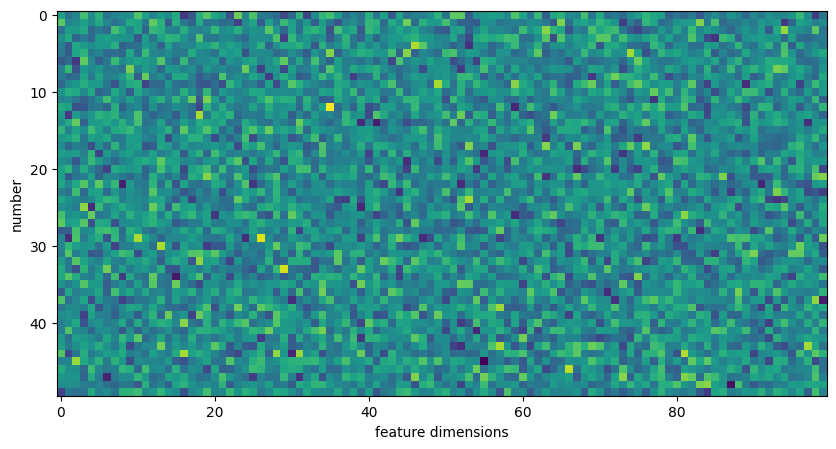

In [18]:
num_test_samples = 50
test_noise = noise(num_test_samples)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(test_noise.cpu())
ax.set_xlabel('feature dimensions')
ax.set_ylabel('number')

In [19]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c5fffd62-a237-4ad1-a894-eb55ebab4fad',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [20]:
# fig, ax = plt.subplots(4,4, figsize=(8,8))
# plt.subplots_adjust(0.05, 0.005, 0.95, 0.95, 0.05, 0.05)
# ax = ax.flatten()
# [a.axis('off') for a in ax]

discriminator.reset()
generator.reset()
t_start = time.time()
duration_avg = 0.0

# Number of epochs for training the GAN
num_epochs = 50

for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(dataloader):
        # 1. Train Discriminator with real images
        real_data = images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data from noise, do not update
        # gradients here - hence add ".detach()"
        noi = noise(real_data.size(0))
        fake_data = generator(noi).detach()
        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = \
                            train_discriminator(d_optimizer, real_data.float(), fake_data)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noi)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Display Progress
        if (n_batch) % 100 == 0:
            
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            p=0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp=test_images[p,0,:,:].numpy()
                        fig.data[p]['z']=numpy_to_plotly(tmp)
                        p+=1
            fig.update_layout(
                title={
                    'text':'epoch {0:} batch {1:} L(D)={2: .3f} L(G)={3: .3f} t={4: .1f}s/it'.format(
                        epoch,n_batch,d_error,g_error,duration_avg),
                    'xanchor':'center',
                    'x':0.5
                })
            
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)
        

ValueError: Using a target size (torch.Size([100, 1, 1, 1])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.